# Introduction to Xarray for Working with Labeled Numerical Data Arrays

<div class="alert alert-success">
    
## This notebook covers
- NumPy multidimensional array data structure
- NumPy data types
- Array creation
- Basic and advanced indexing
- Elementwise array calculations
- Broadcasting
- Mathmatical and logic functions
- Sorting, searching, and counting functions
- Views and copies
- Array manipulation
- Reading and writing array data
</div>

<div class="alert alert-warning">

## Reminders

Remember, you can use Jupyter's built-in table of contents (hamburger on the far left) to jump from heading to heading.

---

This notebook will run in the MSUpy conda environment, which you created in a previous lesson. To load the MSUpy environment in this notebook go to the Kernel tab, select Change Kernel, then select the MSUpy kernel in the pop up window.

---

To turn on line numbers for code cells go to View menu and click Show Line Numbers.

</div>

# I. Importing Necessary Packages

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

# II. Introduction to the Xarray Data Structure

Xarray builds upon many other Python packages, including Numpy, Pandas, Scipy, netCDF4, Matplotlib and more. The Xarray package is most convenient when working with multi-dimensional data stored in netcdf data files. Xarray can also handle zarr, tiff, csv, hdf, and grib files but may require additional dependencies to be installed. 

From the [Xarray documentation](https://docs.xarray.dev/en/stable): "Xarray introduces labels in the form of dimensions, coordinates, and attributes on top of raw Numpy-like multidimensional arrays, which allows for a more intuitive, more concise, and less error-prone developer experience".

We'll cover what all that means shortly! Another gigantic benefit of Xarray is that it integrates well with the Dask package for parallel and distributed computing, which enables fast computation on large data. This aspect of Xarray is a bit too advanced for this course, but it's worth mentioning here, regardless. 

Xarray is under active community development and pushes new updates approximately monthly. This means that developers are actively working on improvements and expanded capabilities and that there will probably be useful updates more frequently than you may be used to.

## Data Structures - DataArray and Dataset

Xarray's core data structures are called the *DataArray* and the *Dataset*. A DataArray is an N-dimensional array of a single data variable with *labels* (metadata) that describe the array *dimensions*, *coordinates*, and *attributes* of the data. Datasets contain one or more DataArrays which share one or more dimensions and coordinates. We will cover what all this Xarray terminology means below, but you can also find more detail in the [Xarray User Guide Terminology page](https://docs.xarray.dev/en/stable/user-guide/terminology.html).

Let's look at an Xarray Dataset object and walk through all its components. We'll load data from the file ```data/nclimgrid/nclimgrid_tmax_199401-202312.nc```. This netcdf file contains the monthly averages of daily maximum surface air temperature (tmax) for 30 years on a spatial grid. The original source of this data is [NOAA Monthly U.S. Climate Gridded Dataset (NClimGrid)](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00332) but the file we are working with has been subset in time and clipped to the state of Mississippi.

We can use the function ```xr.open_dataset()``` to easily load data from the netcdf file into an Xarray Dataset object. As you can see below, when we print the Dataset object ```ds``` to the screen, we get a ton of information. This information is what we meant above by the terms "metadata" or "labels".

In [6]:
# read contents of netcdf file into a Dataset object
ds = xr.open_dataset('data/nclimgrid/nclimgrid_tmax_199401-202312.nc')
ds

<xarray.Dataset> Size: 14MB
Dimensions:  (time: 360, lat: 116, lon: 85)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1994-01-01 1994-02-01 ... 2023-12-01
  * lat      (lat) float32 464B 30.19 30.23 30.27 30.31 ... 34.9 34.94 34.98
  * lon      (lon) float32 340B -91.6 -91.56 -91.52 ... -88.19 -88.15 -88.1
Data variables:
    tmax     (time, lat, lon) float32 14MB ...

A Dataset object will contain one or more DataArrays, which are listed under the "Data variables" section of the info printed to the screen. Our Dataset object ```ds``` contains one DataArray called ```tmax```. 

Click on the paper icon to the right of the DataArray ```tmax``` and you will see even more metadata labels. These are called *variable attributes*. Variable attributes are contained in a Python dictionary where the dictionary keys are the attribute names ("units", "standard_name", etc.) and the dictionary values are the attribute values (e.g., "degree_Celsius","air_temperature"). If we were writing our own data to a netcdf file, we could include any variable attributes we want to help describe the data. But generally, when you are working with climate data, the convention is to use the Climate and Forecast (CF) Metadata Conventions.

<div class="alert alert-danger">

**Sidebar: [Climate and Forecast (CF) Metadata Conventions](https://cfconventions.org)** 

The CF metadata conventions are essentially a set of rules for how climate data should be described and written to data files in order to promote standardized data processing, eliminate ambiguities, and facilitate data sharing. The data file we are working with uses the CF Metadata Conventions and that is why the ```tmax``` variable attributes have those specific names (e.g., "standard_name")- they come from the list of attributes in the [CF Metadata Conventions Appendix A: Attributes](https://cfconventions.org/cf-conventions/cf-conventions.html#attribute-appendix).  
</div>

Now, the data file itself may also have attributes called *file attributes* or *global attributes* that are separate from variable attributes. We can find these attributes in the print out above under the "Attributes" section. This particular file doesn't have any file attributes as indicated by the zero next to the Attributes section. You can imagine, though, that if you were to write your own netcdf file of data, you may want to include file attributes like "institution" or "Conventions" (these examples come from Appendix A of the CF Conventions as well) to indicate inside your data file what institution created that file and what version of the CF Metadata Conventions was used.

Other information we can see about the ```tmax``` DataArray includes the data type (float32) and the dimension names and order (time,lat,lon). Unlike NumPy arrays, where axis 0, axis 1, axis 2, etc can represent anything, there is no ambiguity about what each dimension represents with Xarray data structures because they are labeled. If we look toward the top of the print out we can see each dimension length. The ```tmax``` DataArray which is stored inside the ```ds``` Dataset contains temperature data for 360 times, at 116 latitudes and 85 longitudes.   

Each of our three dimensions is associated with a *coordinate variable*. Coordinate variables (or simply "coordinates") enable us to include very useful metadata about the dimensions of our DataArrays. Click the data stack icon next to any of the coordinates in the print out above and you will see the time, latitude, and longitude arrays of values that are associated with each cell in the DataArray ```tmax```. For example, we can see that our ```tmax``` data begins in January 1994 and ends in December 2023. Click the paper icon next to the time coordinate and you will see that each coordinate variable also has its own attributes! This is because coordinates are DataArray structures. Coordinate variables contain the dimension values and dimension attributes. Coordinates are super important as they allow us to select data using labels instead of index positions as we will see shortly.   

Now let's pull the ```tmax``` DataArray out of the Dataset into a new variable in our notebook. We can access the variables in a dataset using a dot and the variable name.

In [45]:
tx = ds.tmax
tx

<xarray.DataArray 'tmax' (time: 360, lat: 116, lon: 85)> Size: 14MB
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1994-01-01 1994-02-01 ... 2023-12-01
  * lat      (lat) float32 464B 30.19 30.23 30.27 30.31 ... 34.9 34.94 34.98
  * lon      (lon) float32 340B -91.6 -91.56 -91.52 ... -88.19 -88.15 -88.1
Attributes:
    references:     GHCN-Monthly Version 3 (Vose et al. 2011), NCEI/NOAA, htt...
    standard_name:  air_temperature
    units:          degree_Celsius
    valid_min:      -100.0
    valid_max:      100.0
    long_name:      Temperature, monthly average of daily maximums

The print out tells us that our new variable ```tmax``` is an Xarray DataArray object. Notice that all of the variable attributes and coordinates that we saw associated with ```tmax``` inside the Dataset are still attached. We also get a little preview of some of the data values (which isn't too useful here since the preview is all nan).

## Accessing the Components of DataArray Objects

As we saw above, the main components in a DataArray structure are dimensions, coordinates, attributes, and the array of data values. We can access these components using various DataArray properties.
- ```.name``` returns the string name of the DataArray as it was named in the netcdf file
- ```.dims``` returns a tuple of dimension names
- ```.coords``` returns a dictionary-like object of coordinate information
- ```.attrs``` returns a dictionary of attributes
- ```.data``` returns the underlying NumPy array of data values 

In [46]:
# get DataArray name string
tx.name

'tmax'

In [47]:
# get tuple of dimension names
tx.dims

('time', 'lat', 'lon')

In [48]:
# get dictionary of coordinate info
tx.coords

Coordinates:
  * time     (time) datetime64[ns] 3kB 1994-01-01 1994-02-01 ... 2023-12-01
  * lat      (lat) float32 464B 30.19 30.23 30.27 30.31 ... 34.9 34.94 34.98
  * lon      (lon) float32 340B -91.6 -91.56 -91.52 ... -88.19 -88.15 -88.1

In [22]:
# get all variable attributes
tmax.attrs

{'references': 'GHCN-Monthly Version 3 (Vose et al. 2011), NCEI/NOAA, https://www.ncdc.noaa.gov/ghcnm/v3.php',
 'standard_name': 'air_temperature',
 'units': 'degree_Celsius',
 'valid_min': -100.0,
 'valid_max': 100.0,
 'long_name': 'Temperature, monthly average of daily maximums'}

To access only the data values in a DataArray without all the additional metadata attached we can use the ```.data``` property. We can see that the underlying structure holding the data values is a NumPy ndarray!

In [51]:
# get the underlying NumPy array of data values
print(type(tmax.data))
tmax.data

<class 'numpy.ndarray'>


array([[[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        ...,
        [  nan,   nan,   nan, ...,  6.77,  6.79,   nan],
        [  nan,   nan,   nan, ...,  6.78,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        ...,
        [  nan,   nan,   nan, ..., 13.13, 13.16,   nan],
        [  nan,   nan,   nan, ..., 13.1 ,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        ...,
        [  nan,   nan,   nan, ..., 18.04, 18.06,   nan],
        [  nan,   nan,   nan, ..., 17.98,   n

**We can also use coordinate names and attribute names to access specific components directly.** 

For example, we can access a specific coordinate DataArray object by using a dot and the coordinate name.

In [20]:
# get a specific coordinate DataArray object
tmax.lat

<xarray.DataArray 'lat' (lat: 116)> Size: 464B
array([30.187532, 30.2292  , 30.270866, 30.312532, 30.3542  , 30.395866,
       30.437532, 30.4792  , 30.520866, 30.562532, 30.6042  , 30.645866,
       30.687532, 30.7292  , 30.770866, 30.812532, 30.8542  , 30.895866,
       30.937532, 30.9792  , 31.020866, 31.062532, 31.1042  , 31.145866,
       31.187532, 31.2292  , 31.270866, 31.312532, 31.3542  , 31.395866,
       31.437532, 31.4792  , 31.520866, 31.562532, 31.6042  , 31.645866,
       31.687532, 31.7292  , 31.770866, 31.812532, 31.8542  , 31.895866,
       31.937532, 31.9792  , 32.020866, 32.062534, 32.1042  , 32.145866,
       32.187534, 32.2292  , 32.270866, 32.312534, 32.3542  , 32.395866,
       32.437534, 32.4792  , 32.520866, 32.562534, 32.6042  , 32.645866,
       32.687534, 32.7292  , 32.770866, 32.812534, 32.8542  , 32.895866,
       32.937534, 32.9792  , 33.020866, 33.062534, 33.1042  , 33.145866,
       33.187534, 33.2292  , 33.270866, 33.312534, 33.3542  , 33.395866,
       33.437534, 33.4792  , 33.520866, 33.562534, 33.6042  , 33.645866,
       33.687534, 33.7292  , 33.770866, 33.812534, 33.8542  , 33.895866,
       33.937534, 33.9792  , 34.020866, 34.062534, 34.1042  , 34.145866,
       34.187534, 34.2292  , 34.270866, 34.312534, 34.3542  , 34.395866,
       34.437534, 34.4792  , 34.520866, 34.562534, 34.6042  , 34.645866,
       34.687534, 34.7292  , 34.770866, 34.812534, 34.8542  , 34.895866,
       34.937534, 34.9792  ], dtype=float32)
Coordinates:
  * lat      (lat) float32 464B 30.19 30.23 30.27 30.31 ... 34.9 34.94 34.98
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y
    valid_min:      24.562532
    valid_max:      49.3542

To access the attributes of a coordinate we can use the ```.attrs``` property on a coordinate DataArray object.

In [49]:
# get coordinate attributes
tmax.lat.attrs

{'standard_name': 'latitude',
 'long_name': 'latitude',
 'units': 'degrees_north',
 'axis': 'Y',
 'valid_min': 24.562532,
 'valid_max': 49.3542}

Dictionary syntax will get us the attribute value paired with a particular attribute key.

In [50]:
tmax.lat.attrs['standard_name']

'latitude'

Of course this also works for accessing any of the variable attributes attached to ```tmax```.

In [23]:
# get a specific variable attribute
tmax.attrs['units']

'degree_Celsius'

Before we move on, you may have noticed that there is an "Indexes" section in print out of each DataArray and Dataset we've looked at. Indexes are associated with coordinate variables. Coordinate variables are special in that their data values are held in two underlying data structures: a NumPy array and a Pandas Index. This is so the Xarray package can build functionality on top of both NumPy and Pandas. The coordinate variable indexes in a DataArray enable fast label-based indexing as we'll see next. You don't have to worry at all about accessing these indexes directly.

You are probably realizing by now that the Xarray data structures are very complex as compared to the other data structures we've learned about thus far in the course. But this complexity will actually make data analysis a lot simpler and less error prone.

## Using NumPy Array Properties on Xarray DataArrays

Because the DataArray's underlying array structure is a NumPy array, most of the NumPy array properties work on Xarray DataArrays just as they would with a NumPy array. 

In [55]:
# tmax is a DataArray
# most of the NumPy array properties work on Xarray DataArrays

print(tmax.shape)   # tuple of dimension lengths
print(tmax.ndim)    # number of dimensions
print(tmax.size)    # total number of elements (360*116*85)
print(tmax.dtype)   # data type
print(tmax.data.itemsize)  # bytes of a single array element, only works on NumPy array not DataArray
print(tmax.nbytes)  # total bytes consumed by the NumPy array

(360, 116, 85)
3
3549600
float32
4
14198400


In [56]:
# the coordinate tmax.time is a DataArray
# most of the NumPy array properties work on Xarray DataArrays

print(tmax.time.shape)   # tuple of dimension lengths
print(tmax.time.ndim)    # number of dimensions
print(tmax.time.size)    # total number of elements 
print(tmax.time.dtype)   # data type
print(tmax.time.data.itemsize)  # bytes of a single array element, only works on NumPy array not DataArray
print(tmax.time.nbytes)  # total bytes consumed by the NumPy array

(360,)
1
360
datetime64[ns]
8
2880


<div class="alert alert-info"> 

## Exercise 1: Create a NumPy Array from Scratch and Access Its Attributes

Create a 2-dimensional 32-bit integer array called ```myArr2d``` with 4 rows and 3 columns.
</div>

In [62]:
tx.time.indexes

Indexes:
    time     DatetimeIndex(['1994-01-01', '1994-02-01', '1994-03-01', '1994-04-01',
               '1994-05-01', '1994-06-01', '1994-07-01', '1994-08-01',
               '1994-09-01', '1994-10-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='time', length=360, freq=None)

# III. Indexing and Slicing

3

In [30]:
tmax.size

3549600

In [52]:
print(tmax.nbytes)
print(tmax.data.nbytes)

14198400
14198400


In [32]:
tmax.shape

(360, 116, 85)

In [19]:
tmax.data.dtype
# test.dtype

dtype('float32')

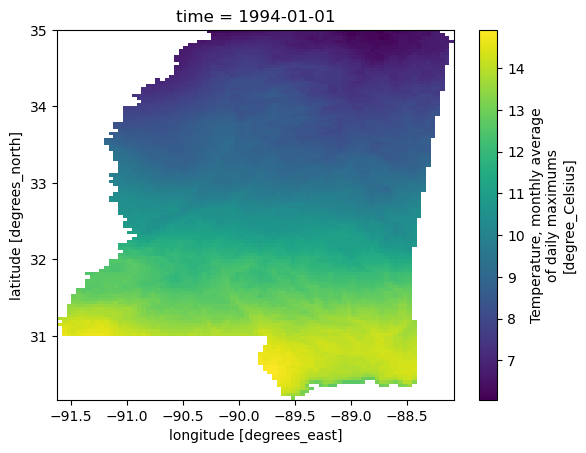

In [5]:
ds.tmax.isel(time=0).plot()

A dimension of a Xarray DataArray is the same as an axis of a NumPy ndarray except that each dimension of a DataArray is labeled with a name. For example, a 3D NumPy array would have the dimensions axis 0, axis 1, and axis 2 where each axis would represent something like time, latitude, and longitude. The equivalent Xarray 3D DataArray would have dimensions with actual names "time", "latitude", and "longitude"   


Datasets contain one or more DataArrays which share one or more dimensions and coordinates. Each variable in a Dataset has its own attributes and the Dataset itself can have its own attributes as well (which come from the file attributes in each netcdf). 

Details of all xarray functions (including what parameters to include as function inputs and what each function returns) can be found in the **[xarray API reference](https://docs.xarray.dev/en/stable/api.html)**. Xarray has pretty great documentation with usage examples, definitely check the **[xarray getting started](https://docs.xarray.dev/en/stable/getting-started-guide/index.html)** and **[xarray user guide](https://docs.xarray.dev/en/stable/user-guide/index.html)** documentation for help as you are learning. If you are stuck on something, stack overflow and xarray's issue documentation on github is also useful. I personally often end up at those sites from google searches "python xarray how to ___". 




## Data Types



# Intro to Netcdf
especially files that are written using Climate and Forecast Metadata Conventions ([CF Metadata Conventions](https://cfconventions.org)). These metadata conventions are essentially a set of rules for how climate data should be described and written to data files in order to promote standardized data processing, eliminate ambiguities, and facilitate data sharing.




With xarray, when we print a variable, instead of getting the values of that variable what we get (usually) is a view of all the metadata labels that are attached to the variable. The information above shows us that our pr data is the daily total precipitation aggregated from midnight to midnight local time each day, has units of mm per day, and is called 'prcp' in the netcdf file.  

We can also see that the data has 3 dimensions (time, lat, lon), the length of each dimension, and that each dimension is a "coordinate", which are essentially additional labels. Click on the paper and data stack icons to the right of each coordinate. Using the paper icon, you can see that each coordinate has its own attributes (standard_name, units, etc.). Using the data stack icon, you can see that each coordinate is also an array of values, similar to an index in Pandas. The beauty of coordinates is that they allow us to easily select a subset of the data variable using labels that correspond to the coordinate values. 

Definitions for xarray terminology such as DataArray, Dataset, variable, dimension, coordinate, attribute can all be found in xarray's user guide on the **[xarray terminology page](https://docs.xarray.dev/en/stable/user-guide/terminology.html)**.

## Array Attributes

Each ndarray has a number of *attributes*. These may also be called array *properties*. We've already seen one of these above with ```.shape```. The others we will cover are ```.ndim```, ```.size```, ```.dtype```, ```.itemsize```, and ```.nbytes```. The full list of attributes can be found in

# IV. Elementwise Operations, Broadcasting, Comparison Operators, Logic Operators, and Logic Functions

# V. Math Functions, Array Creation Functions

# VI. Useful Xarray Functions for Geosciences

# VII. Array Manipulation

# VIII. Converting Numpy and Pandas Data Structures to Xarray Data Structures

Your data doesn't need to be provided in netcdf format in order to use xarray data structures. You can hold any numerical data array in an Xarray DataArray or Dataset. If you have metadata (or labels) for the dimensions of your data, you can add that into the DataArray or Dataset object. Here we'll read in data that is provided in a csv file and create an Xarray DataArray.

Why would you want to do this?

# IX. Input/Output (I/O) with Xarray

# X. Exercise: Putting it All Together

# XI. At a Glance: Language Covered

The NumPy functionality that we covered at a glance...

## NumPy Functions

```np.all()```, ```np.any()```, ```np.arange()```, ```np.argsort()```, ```np.argwhere()```,  ```np.array()```, ```np.ceil()```, ```np.cos()```, ```np.concatenate()```, ```np.cumsum()```, ```np.diff()```, ```np.empty()```, ```np.expand_dims()```, ```np.flatten()```, ```np.float16()```, ```np.floor()```, ```np.full()```, ```np.genfromtxt()```, ```np.isfinite()```, ```np.isnan()```,
```np.linspace()```,  ```np.load()```, ```np.loadtxt()```, ```np.log()```, ```np.logical_and()```, ```np.logical_or()```, ```np.logical_not()```, ```np.max()```, ```np.mean()```, ```np.median()```,  ```np.min()```, ```np.nan_to_num()```, ```np.ones()```, ```np.percentile()```, ```np.ptp()```, ```np.quantile()```, ```np.radians()```, ```np.random_default_rng()```, ```np.reshape()```, ```np.round()```, ```np.save()```, ```np.savetxt()```, ```np.savez()```, ```np.sin()```, ```np.sort()```, ```np.squeeze()```, ```np.stack()```, ```np.std()```, ```np.sum()```, ```np.trunc()```, ```np.unique()```, ```np.var()```, ```np.where()```, ```np.zeros()```,


## NumPy data structure (ndarray) methods
```.astype()```, ```.sum()```

## NumPy data structure (ndarray) attributes

```.dtype```, ```.itemsize```, ```.nbytes```, ```.ndim```, ```.shape```, ```.size```  


## NumPy random number generator object (rng) methods
```.integers()```, ```.random()```, ```.uniform()``` 


## NumPy constants

```np.inf```, ```np.nan```, ```np.newaxis```

## Functions from other packages
```glob.glob()```, ```matplotlib.pyplot.imshow()```, ```matplotlib.pyplot.text()```, ```pandas.DataFrame()```, ```pandas.read_csv()```, ```pandas.dataframe.to_csv()```, ```pandas.dataframe.to_numpy()``` 

<div class="alert alert-success">

# XV. Learning More About NumPy

For more about NumPy, start on the [NumPy website](https://numpy.org/) where you can find:

- the getting started doc, user guide, and API reference documentation https://numpy.org/doc/stable/
- beginner and advanced tutorials, book suggestions, and videos links https://numpy.org/learn/

</div>